# Large-Scale Overlapping Genes Analysis

This notebook scales the overlapping gene analysis to all 12 protein families found in `Project/bmDCA`.

**Pipeline:**
1.  **Temperature Optimization**: Automatically find the optimal temperature ($T_{opt}$) for each of the 12 genes where simulated energy matches natural mean.
2.  **Pairwise Scan**: Run overlap simulations for all unique pairs ($N=66$) using the $T_{opt}$ values.
3.  **Analysis**: Aggregate results into a summary DataFrame and visualize with Heatmaps and Dot Plots.

In [28]:
# --- IMPORTS ---
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import glob
import time
import json

# Add current directory to path to import overlappingGenes
sys.path.append(os.getcwd())
import overlappingGenes as og

plt.style.use('seaborn-v0_8-whitegrid')

In [29]:
# --- DATA LOADING ---

BASE_DIR = "bmDCA"
ALL_PF_DIRS = sorted([d for d in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, d)) and d.startswith("PF")])
print(f"Found {len(ALL_PF_DIRS)} Protein Families: {ALL_PF_DIRS}")

# Cache for parameters to avoid reloading 66 times
PARAMS_CACHE = {}
NATURAL_STATS_CACHE = {}

def get_params_and_stats(pf_name):
    if pf_name in PARAMS_CACHE:
        return PARAMS_CACHE[pf_name], NATURAL_STATS_CACHE[pf_name]
    
    # Load DCA Params
    param_file = os.path.join(BASE_DIR, pf_name, f"{pf_name}_params.dat")
    J, h = og.extract_params(param_file)
    PARAMS_CACHE[pf_name] = [J, h]
    
    # Load Natural Stats
    nat_file = os.path.join(BASE_DIR, pf_name, f"{pf_name}_naturalenergies.txt")
    energies = og.load_natural_energies(nat_file)
    NATURAL_STATS_CACHE[pf_name] = (np.mean(energies), np.std(energies))
    
    return [J, h], (np.mean(energies), np.std(energies))

Found 12 Protein Families: ['PF00004', 'PF00041', 'PF00072', 'PF00076', 'PF00096', 'PF00153', 'PF00271', 'PF00397', 'PF00512', 'PF00595', 'PF02518', 'PF07679']


In [30]:
# --- 1. TEMPERATURE OPTIMIZATION ---

OPTIMAL_TEMPS_FILE = "optimal_temperatures.json"

def find_optimal_temperature(pf_name, temp_range=np.linspace(0.6, 1.4, 25), n_trials=10):
    """Finds T where Mean Simulated Energy is closest to Mean Natural Energy."""
    params, (nat_mean, nat_std) = get_params_and_stats(pf_name)
    J, h = params
    len_prot = len(h) // 21
    
    best_t = None
    min_dist = float('inf')
    
    print(f"Optimizing {pf_name} (Target: {nat_mean:.2f})...", end="")
    
    for t in temp_range:
        sim_energies = []
        for _ in range(n_trials):
            # Use dummy overlap setup
            initial_seq = og.initial_seq_no_stops(len_prot, len_prot, 60, quiet=True)
            
            *_, final_Es = og.overlapped_sequence_generator_int(
                params, params, initial_seq, 
                numberofiterations=250000,
                whentosave=1.0, quiet=True,
                T1=t, T2=1000.0
            )
            sim_energies.append(final_Es[0])
            
        avg_sim = np.mean(sim_energies)
        dist = abs(avg_sim - nat_mean)
        
        if dist < min_dist:
            min_dist = dist
            best_t = t
            
    print(f" Best T = {best_t:.2f} (Dist: {min_dist:.2f})")
    return best_t

# Run Phase 1 with Persistence
OPTIMAL_TEMPS = {}

# 1. Try to load existing
if os.path.exists(OPTIMAL_TEMPS_FILE):
    print(f"Loading optimal temperatures from {OPTIMAL_TEMPS_FILE}...")
    with open(OPTIMAL_TEMPS_FILE, 'r') as f:
        OPTIMAL_TEMPS = json.load(f)
else:
    print("No localized temperature file found. Starting optimization...")

# 2. Check for missing PFs and run optimization
data_changed = False
for pf in ALL_PF_DIRS:
    if pf not in OPTIMAL_TEMPS:
        print(f"Finding Optimal T for {pf}...")
        OPTIMAL_TEMPS[pf] = find_optimal_temperature(pf, temp_range=np.linspace(0.6, 1.4, 25), n_trials=15)
        data_changed = True
    else:
        print(f"{pf}: Using cached T = {OPTIMAL_TEMPS[pf]}")

# 3. Save if updated
if data_changed:
    print(f"Saving updated temperatures to {OPTIMAL_TEMPS_FILE}...")
    with open(OPTIMAL_TEMPS_FILE, 'w') as f:
        json.dump(OPTIMAL_TEMPS, f, indent=4)

print("Final Optimal Temps:", OPTIMAL_TEMPS)

Loading optimal temperatures from optimal_temperatures.json...
PF00004: Using cached T = 0.8666666666666667
PF00041: Using cached T = 1.0
PF00072: Using cached T = 1.0
PF00076: Using cached T = 0.8333333333333333
PF00096: Using cached T = 0.8666666666666667
PF00153: Using cached T = 0.8333333333333333
PF00271: Using cached T = 0.9333333333333333
PF00397: Using cached T = 0.8333333333333333
PF00512: Using cached T = 0.9666666666666666
PF00595: Using cached T = 0.8333333333333333
PF02518: Using cached T = 1.0666666666666667
PF07679: Using cached T = 0.8999999999999999
Final Optimal Temps: {'PF00004': 0.8666666666666667, 'PF00041': 1.0, 'PF00072': 1.0, 'PF00076': 0.8333333333333333, 'PF00096': 0.8666666666666667, 'PF00153': 0.8333333333333333, 'PF00271': 0.9333333333333333, 'PF00397': 0.8333333333333333, 'PF00512': 0.9666666666666666, 'PF00595': 0.8333333333333333, 'PF02518': 1.0666666666666667, 'PF07679': 0.8999999999999999}


In [31]:
# --- 2. PAIRWISE SCAN ---

ITERATIONS = 250000
N_TRIALS = 20

def run_pairwise_scan(pf_list, optimal_temps):
    summary_data = []
    
    # Generate Pairs (Exclude self-pairs)
    pairs = []
    for i in range(len(pf_list)):
        for j in range(i + 1, len(pf_list)): # Start from i + 1 to avoid self-pairs
            pairs.append((pf_list[i], pf_list[j]))
            
    total_pairs = len(pairs)
    print(f"Starting Scan of {total_pairs} unique pairs...")
    
    start_time_all = time.time()
    
    for idx, (pf1, pf2) in enumerate(pairs):
        pair_start = time.time()
        print(f"[{idx+1}/{total_pairs}] Scanning {pf1} vs {pf2}...", end="")
        
        # Load Params
        params1, (nat_mean1, _) = get_params_and_stats(pf1)
        params2, (nat_mean2, _) = get_params_and_stats(pf2)
        
        t1 = optimal_temps.get(pf1, 1.0)
        t2 = optimal_temps.get(pf2, 1.0)
        
        len1 = len(params1[1]) // 21
        len2 = len(params2[1]) // 21
        
        # 3-0 Reading Frame Overlaps
        max_overlap = min(len1, len2) * 3 - 6 # Safety buffer
        overlap_range = np.arange(12, min(90, max_overlap), 3)
        
        print(f" Overlaps: {len(overlap_range)} | Trials/Ov: {N_TRIALS}")
        
        for ov in overlap_range:
            trial_e1 = []
            trial_e2 = []
            
            for _ in range(N_TRIALS):
                init_seq = og.initial_seq_no_stops(len1, len2, ov, quiet=True)
                *_, (e1, e2) = og.overlapped_sequence_generator_int(
                    params1, params2, init_seq,
                    numberofiterations=ITERATIONS,
                    whentosave=1.0, 
                    quiet=True,
                    T1=t1, T2=t2
                )
                trial_e1.append(e1)
                trial_e2.append(e2)
            
            # Save Summary
            summary_data.append({
                'PF1': pf1, 'PF2': pf2, 'Overlap': ov,
                'Mean_E1': np.mean(trial_e1), 'Std_E1': np.std(trial_e1),
                'Mean_E2': np.mean(trial_e2), 'Std_E2': np.std(trial_e2),
                'Nat_Mean1': nat_mean1, 'Nat_Mean2': nat_mean2,
                'Dist_1': abs(np.mean(trial_e1) - nat_mean1),
                'Dist_2': abs(np.mean(trial_e2) - nat_mean2)
            })
        
        pair_dur = time.time() - pair_start
        print(f"   -> Completed in {pair_dur:.1f}s")
            
    total_dur = time.time() - start_time_all
    print(f"\nFull Scan Complete in {total_dur/60:.1f} minutes!")
    return pd.DataFrame(summary_data)

results_df = run_pairwise_scan(ALL_PF_DIRS, OPTIMAL_TEMPS)
results_df.to_csv("large_scale_results.csv")

Starting Scan of 66 unique pairs...
[1/66] Scanning PF00004 vs PF00041... Overlaps: 26 | Trials/Ov: 20


SystemError: CPUDispatcher(<function overlapped_sequence_generator_int at 0x00000174E3A62FC0>) returned a result with an exception set

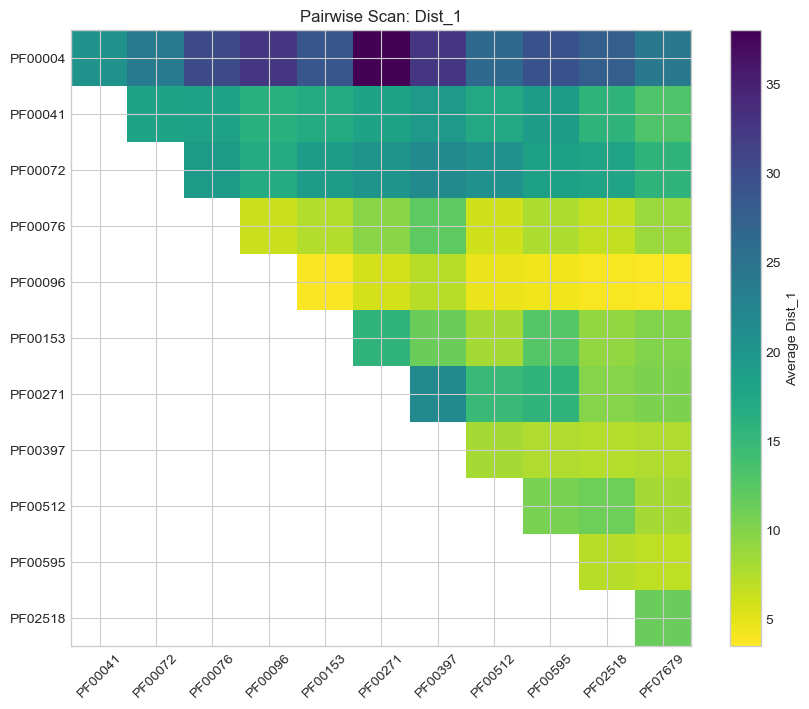

In [32]:
# --- 3. HEATMAP VISUALIZATION ---

def plot_heatmap(df, metric='Dist_1'):
    # Aggregate by Pair (Take mean distance across all overlaps per pair)
    pivot = df.groupby(['PF1', 'PF2'])[metric].mean().unstack()
    
    plt.figure(figsize=(10, 8))
    plt.imshow(pivot, cmap='viridis_r', aspect='auto')
    plt.colorbar(label=f'Average {metric}')
    
    plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=45)
    plt.yticks(range(len(pivot.index)), pivot.index)
    plt.title(f"Pairwise Scan: {metric}")
    plt.show()

plot_heatmap(results_df)


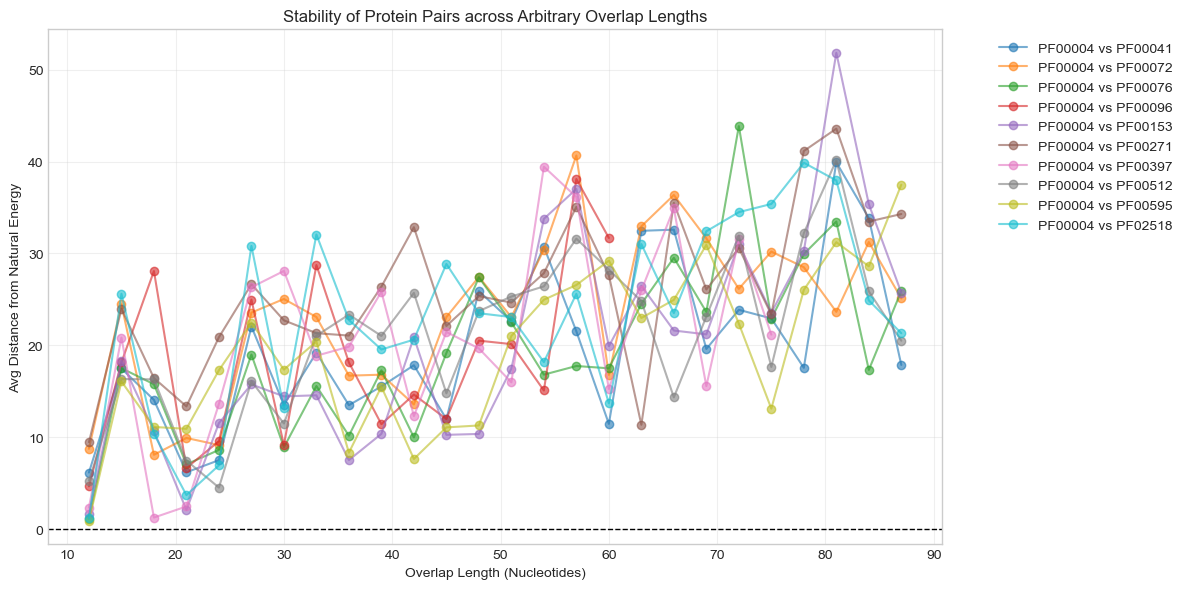

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the results
df = pd.read_csv('large_scale_results.csv')

# ---------------------------------------------------------
# Plot 1: Energy Stability Profiles (The "Arbitrary" Proof)
# ---------------------------------------------------------
# This plots the deviation from natural energy as overlap increases.
# Ideally, we want these lines to be close to 0.

plt.figure(figsize=(12, 6))

# Get unique pairs for labeling (or just plot all dists)
# We plot standard deviation units or raw distance? Let's stick to your Dist_1/Dist_2
# We will plot the AVERAGE distance of the two proteins for each overlap step across all pairs
# or better yet, plot individual "traces" for each pair to show robustness.

# Filter for a few representative pairs to keep plot clean, or plot all with low alpha
unique_pairs = df[['PF1', 'PF2']].drop_duplicates().values

for p1, p2 in unique_pairs[:10]: # Plot first 10 pairs as examples
    subset = df[(df['PF1'] == p1) & (df['PF2'] == p2)]
    
    # Calculate Total Distance metric (e.g., sum of distances for both)
    # You could also just plot Dist_1 or Dist_2 separately
    total_dist = (subset['Dist_1'] + subset['Dist_2']) / 2
    
    plt.plot(subset['Overlap'], total_dist, marker='o', alpha=0.6, label=f"{p1} vs {p2}")

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Overlap Length (Nucleotides)')
plt.ylabel('Avg Distance from Natural Energy')
plt.title('Stability of Protein Pairs across Arbitrary Overlap Lengths')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


note, in the heat map, the empty boxes are due to some genes being shorter than others, not a lack of convergence

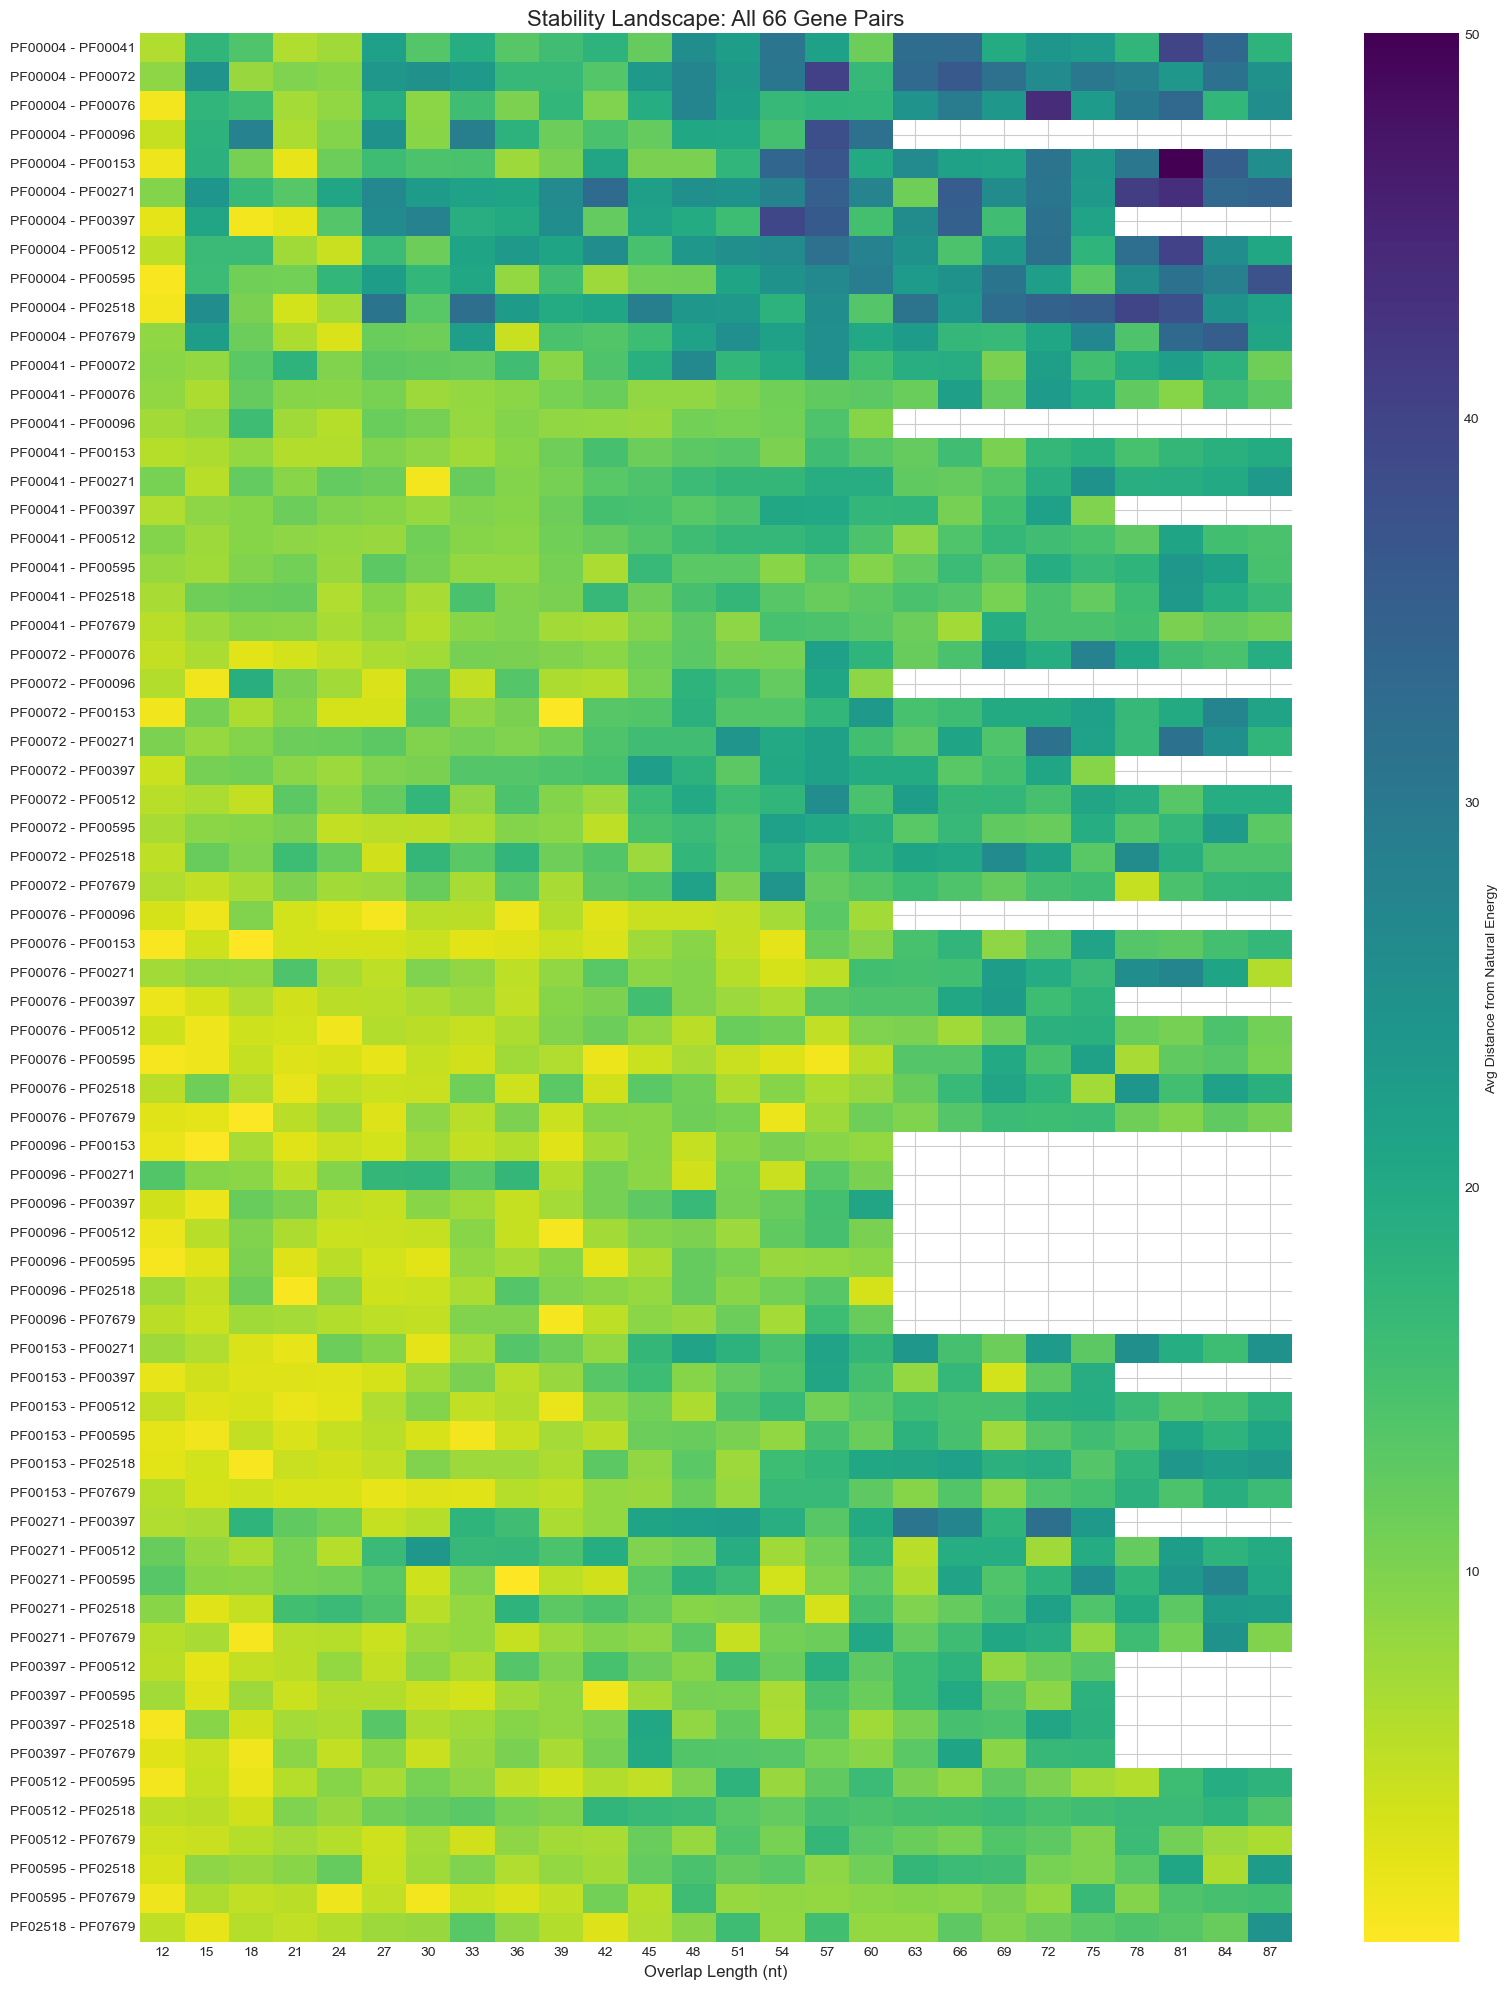

In [35]:
# ---------------------------------------------------------
# Plot 2: Full Stability Heatmap (All 66 Pairs)
# ---------------------------------------------------------
plt.figure(figsize=(16, 20))
sns.heatmap(pivot_df, cmap="viridis_r", vmax=50, cbar_kws={'label': 'Avg Distance from Natural Energy'})
plt.title('Stability Landscape: All 66 Gene Pairs', fontsize=16)
plt.xlabel('Overlap Length (nt)', fontsize=12)
plt.ylabel('')
plt.tight_layout()
plt.show()

Yellow / Light Green: The pair coexists easily with almost no stability loss.
Dark Blue / Purple: The pair is chemically "unhappy" and unstable; the overlap constraint is causing significant structural frustration.

need to update logic to take best energy not final energy as this might not represent the true difficulty of overlap